<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/ODE/Experiment_Case_ODE_%26_RNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code and explaination from:

https://spaces.ac.cn/archives/5643
https://github.com/GlassyWing/ode_rnn

# Ordinary Differential Equation
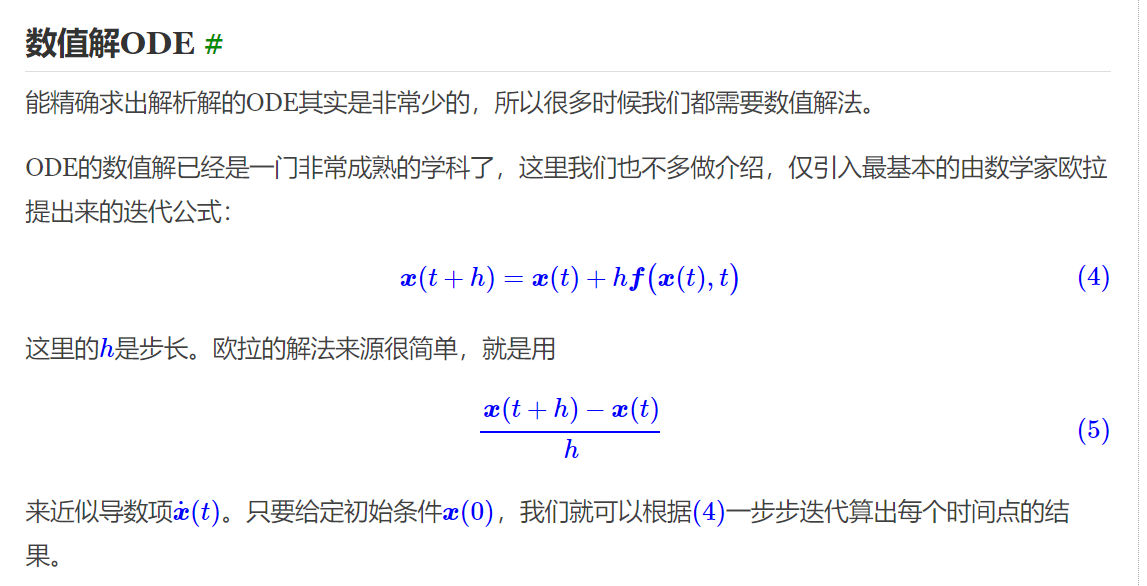

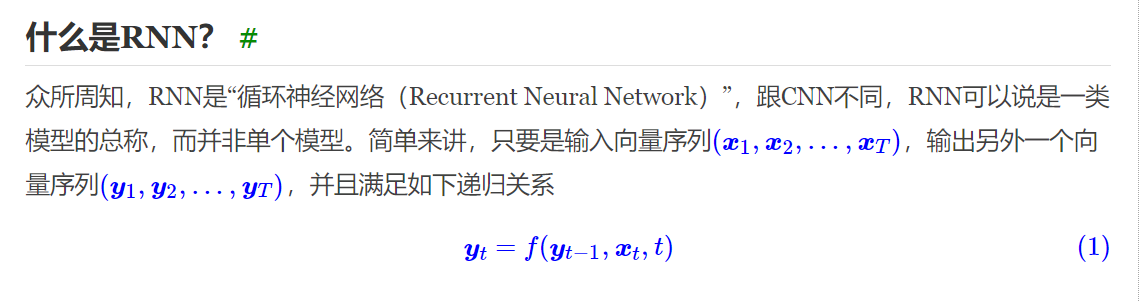




## Case1: a known function

$$
\left\{\begin{array}{l}
\frac{d x_{1}}{d t}=r_{1} x_{1}\left(1-\frac{x_{1}}{N_{1}}\right)-a_{1} x_{1} x_{2} \\
\frac{d x_{2}}{d t}=r_{2} x_{2}\left(1-\frac{x_{2}}{N_{2}}\right)-a_{2} x_{1} x_{2}
\end{array}\right.
$$

In [2]:
import torch.nn as nn
import torch
from torch.optim import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt

In [12]:
class ODE_RNN(nn.Module):

    def __init__(self, steps, h):
        super().__init__()
        self.steps = steps
        self.h = h

        self.weights = nn.Parameter(
            torch.tensor([0.1, 0.1, 0.001, 0.001, 0.001, 0.001], dtype=torch.float32)
            , requires_grad=True)

    def step_do(self, state):
        x = state
        r1, r2, a1, a2, iN1, iN2 = (self.weights[0], self.weights[1],
                                    self.weights[2], self.weights[3],
                                    self.weights[4], self.weights[5])
        _1 = r1 * x[:, 0] * (1 - iN1 * x[:, 0]) - a1 * x[:, 0] * x[:, 1]
        _2 = r2 * x[:, 1] * (1 - iN2 * x[:, 1]) - a2 * x[:, 0] * x[:, 1]

        _ = torch.stack((_1, _2), dim=-1)

        step_out = x + self.h * torch.clamp(_, -1e5, 1e5)
        return step_out, step_out

    def forward(self, init):
        state = init
        outputs = []
        for step in range(self.steps):
            step_out, state = self.step_do(state)
            outputs.append(step_out)

        outputs = torch.stack(outputs, dim=1)

        return outputs


mse_loss = torch.nn.MSELoss(reduction='none')


def ode_loss(y_true, y_pred):
    mask = torch.sum(y_true, dim=-1, keepdim=True) > 0
    mask = mask.float()

    return torch.sum(mask * mse_loss(y_true, y_pred)) / mask.sum()


if __name__ == '__main__':

    steps, h = 50, 1

    series = {0: [100, 150],
              10: [165, 283],
              15: [197, 290],
              30: [280, 276],
              36: [305, 269],
              40: [318, 266],
              42: [324, 264]}

    X = np.array([series[0]])
    Y = np.zeros((1, steps, 2))

    for i, j in series.items():
        if i != 0:
            Y[0, int(i / h) - 1] += series[i]

    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()

    model = ODE_RNN(steps, h)
    optimizer = Adam(model.parameters(), lr=1e-4)

    for epoch in range(10000):
        outputs = model(X)
        loss = ode_loss(Y, outputs)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        print(epoch, loss.item())

    with torch.no_grad():
        result = model(torch.tensor([[100, 150]], dtype=torch.float32))[0]
        times = np.arange(1, steps + 1) * h

    plt.clf()
    plt.plot(times, result[:, 0], color='blue')
    plt.plot(times, result[:, 1], color='green')

    plt.plot(list(series.keys()), [i[0] for i in series.values()], 'o', color='blue')
    plt.plot(list(series.keys()), [i[1] for i in series.values()], 'o', color='green')

流式输出内容被截断，只能显示最后 5000 行内容。
5000 150.8030242919922
5001 159.68719482421875
5002 175.1804656982422
5003 169.33767700195312
5004 154.17666625976562
5005 151.7027130126953
5006 161.71873474121094
5007 165.5666046142578
5008 156.5295867919922
5009 150.13827514648438
5010 154.21421813964844
5011 159.39805603027344
5012 157.03709411621094
5013 150.89793395996094
5014 150.1748504638672
5015 154.1352081298828
5016 155.3538055419922
5017 152.15292358398438
5018 149.12208557128906
5019 149.94735717773438
5020 152.3079833984375
5021 152.23277282714844
5022 149.95150756835938
5023 148.3338165283203
5024 148.9487762451172
5025 150.3001708984375
5026 150.2829132080078
5027 148.94686889648438
5028 147.76100158691406
5029 147.7860565185547
5030 148.5416259765625
5031 148.87255859375
5032 148.36082458496094
5033 147.47314453125
5034 146.98948669433594
5035 147.1278533935547
5036 147.50314331054688
5037 147.6232452392578
5038 147.30697631835938
5039 146.8018798828125
5040 146.43582153320312
5041 146.3696

NameError: ignored

$$
\begin{array}{c|ccccccc}
\hline \text { time } & 0 & 10 & 15 & 30 & 36 & 40 & 42 \\
\hline x_{1} & 100 & 165 & 197 & 280 & 305 & 318 & 324 \\
\hline x_{2} & 150 & 283 & 290 & 276 & 269 & 266 & 264 \\
\hline
\end{array}
$$

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <menclose notation="top bottom" data-padding="0">
    <mtable columnalign="center center center center center center center center" columnspacing="1em" rowspacing="4pt" columnlines="solid none none none none none none" rowlines="solid solid" frame="">
      <mtr>
        <mtd>
          <mtext>&#x65F6;&#x95F4;</mtext>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>10</mn>
        </mtd>
        <mtd>
          <mn>15</mn>
        </mtd>
        <mtd>
          <mn>30</mn>
        </mtd>
        <mtd>
          <mn>36</mn>
        </mtd>
        <mtd>
          <mn>40</mn>
        </mtd>
        <mtd>
          <mn>42</mn>
        </mtd>
      </mtr>
      <mtr>
        <mtd>
          <msub>
            <mi>x</mi>
            <mn>1</mn>
          </msub>
        </mtd>
        <mtd>
          <mn>100</mn>
        </mtd>
        <mtd>
          <mn>165</mn>
        </mtd>
        <mtd>
          <mn>197</mn>
        </mtd>
        <mtd>
          <mn>280</mn>
        </mtd>
        <mtd>
          <mn>305</mn>
        </mtd>
        <mtd>
          <mn>318</mn>
        </mtd>
        <mtd>
          <mn>324</mn>
        </mtd>
      </mtr>
      <mtr>
        <mtd>
          <msub>
            <mi>x</mi>
            <mn>2</mn>
          </msub>
        </mtd>
        <mtd>
          <mn>150</mn>
        </mtd>
        <mtd>
          <mn>283</mn>
        </mtd>
        <mtd>
          <mn>290</mn>
        </mtd>
        <mtd>
          <mn>276</mn>
        </mtd>
        <mtd>
          <mn>269</mn>
        </mtd>
        <mtd>
          <mn>266</mn>
        </mtd>
        <mtd>
          <mn>264</mn>
        </mtd>
      </mtr>
    </mtable>
  </menclose>
</math>

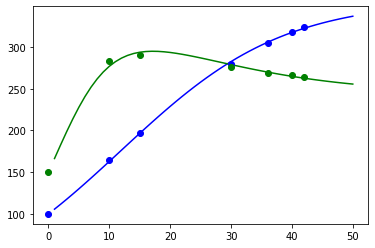

In [13]:
plt.clf()
plt.plot(times, result[:, 0], color='blue')
plt.plot(times, result[:, 1], color='green')

plt.plot(list(series.keys()), [i[0] for i in series.values()], 'o', color='blue')
plt.plot(list(series.keys()), [i[1] for i in series.values()], 'o', color='green')

# Case 2

using Eular to approximate

In [14]:
import torch.nn as nn
import torch
from torch.optim import Adam, SGD
import numpy as np
import matplotlib.pyplot as plot

In [17]:
class ODE_RNN_Eular(nn.Module):

    def __init__(self, steps, input_size, hidden_size):
      super().__init__()
      self.steps = steps
      self.input_size = input_size
      self.hidden_size = hidden_size
      ## 多层全连接网络，用于拟合微分方程
      self.d_f = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.SELU(),
          nn.Linear(hidden_size, hidden_size),
          nn.SELU(),
          nn.Linear(hidden_size, input_size)
      )

    def step_do(self,state):
      x = state

      _ = self.d_f(x)

      step_out = x + torch.clamp(_, -1e5, 1e5)
      return step_out, step_out

    def forward(self, init, steps=None):
        state = init
        outputs = []

        steps = self.steps if steps is None else steps

        for step in range(steps):
            step_out, state = self.step_do(state)
            outputs.append(step_out)

        outputs = torch.stack(outputs, dim=1)

        return outputs 

流式输出内容被截断，只能显示最后 5000 行内容。
5000 191.59617614746094
5001 191.4361114501953
5002 191.2777099609375
5003 191.1195068359375
5004 190.96051025390625
5005 190.80174255371094
5006 190.6434326171875
5007 190.48577880859375
5008 190.3279571533203
5009 190.17076110839844
5010 190.01353454589844
5011 189.8564910888672
5012 189.6995086669922
5013 189.5431671142578
5014 189.3871307373047
5015 189.2312469482422
5016 189.0754852294922
5017 188.91993713378906
5018 188.7650604248047
5019 188.61004638671875
5020 188.45542907714844
5021 188.30101013183594
5022 188.14698791503906
5023 187.99310302734375
5024 187.83961486816406
5025 187.6859588623047
5026 187.53294372558594
5027 187.3804931640625
5028 187.2279815673828
5029 187.07569885253906
5030 186.92352294921875
5031 186.77268981933594
5032 186.62054443359375
5033 186.46986389160156
5034 186.3185577392578
5035 186.1676025390625
5036 186.0176544189453
5037 185.8681182861328
5038 185.7180633544922
5039 185.5686492919922
5040 185.4198455810547
5041 185.27

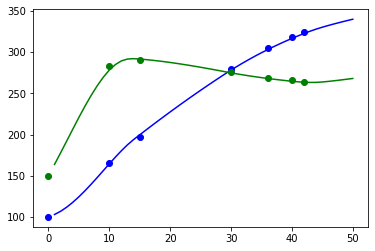

In [18]:

mse_loss = torch.nn.MSELoss(reduction='none')


def ode_loss(y_true, y_pred):
    mask = torch.sum(y_true, dim=-1, keepdim=True) > 0
    mask = mask.float()

    return torch.sum(mask * mse_loss(y_true, y_pred)) / mask.sum()


if __name__ == '__main__':

    steps, h = 50, 1

    series = {0: [100, 150],
              10: [165, 283],
              15: [197, 290],
              30: [280, 276],
              36: [305, 269],
              40: [318, 266],
              42: [324, 264]}

    X = np.array([series[0]])
    Y = np.zeros((1, steps, 2))

    for i, j in series.items():
        if i != 0:
            Y[0, int(i / h) - 1] += series[i]

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    model = ODE_RNN_Eular(steps, input_size=2, hidden_size=64)
    optimizer = Adam(model.parameters(), lr=1e-3)

    for epoch in range(10000):
        outputs = model(X)
        loss = ode_loss(Y, outputs)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        print(epoch, loss.item())

    with torch.no_grad():
        result = model(torch.tensor([[100, 150]], dtype=torch.float32))[0]
        times = np.arange(1, steps + 1) * h

    plot.clf()
    plot.plot(times, result[:, 0], color='blue')
    plot.plot(times, result[:, 1], color='green')

    plot.plot(list(series.keys()), [i[0] for i in series.values()], 'o', color='blue')
    plot.plot(list(series.keys()), [i[1] for i in series.values()], 'o', color='green')

In [19]:
steps, h = 50, 1

series = {0: [100, 150],
          10: [165, 283],
          15: [197, 290],
          30: [280, 276],
          36: [305, 269],
          40: [318, 266],
          42: [324, 264]}

X = np.array([series[0]])
Y = np.zeros((1, steps, 2))

for i, j in series.items():
    if i != 0:
        Y[0, int(i / h) - 1] += series[i]


In [20]:
X

array([[100, 150]])

In [22]:
Y.shape

(1, 50, 2)

# Case3: More complicated NN

In [23]:
import torch.nn as nn
import torch
from torch.optim import Adam, SGD
import numpy as np
import matplotlib.pyplot as plot


class ODE_LSTM(nn.Module):

    def __init__(self, steps, input_size, hidden_size, num_layers):
        super().__init__()
        self.steps = steps

        self.en = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.de = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        self.o_net = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.SELU(),
            nn.Linear(hidden_size, input_size)
        )

    def forward(self, init, steps=None):
        steps = self.steps if steps is None else steps

        # 实际上不需要进行输入，只是官方实现需要输入
        zeros = torch.zeros(init.shape[0],
                            steps,
                            init.shape[1],
                            dtype=init.dtype)

        _, init_state = self.en(init.unsqueeze(1))

        outputs, _ = self.de(zeros, init_state)

        # steps
        outputs = self.o_net(outputs)

        return outputs

0 1.7411314249038696
1 1.7312169075012207
2 1.7213211059570312
3 1.7114423513412476
4 1.7015784978866577
5 1.6917266845703125
6 1.681883454322815
7 1.6720466613769531
8 1.6622133255004883
9 1.6523804664611816
10 1.6425446271896362
11 1.6327024698257446
12 1.6228498220443726
13 1.612981915473938
14 1.6031018495559692
15 1.5932430028915405
16 1.5832525491714478
17 1.5731829404830933
18 1.5630601644515991
19 1.5528830289840698
20 1.542651653289795
21 1.5323647260665894
22 1.5220199823379517
23 1.5116151571273804
24 1.501146674156189
25 1.490610122680664
26 1.4800020456314087
27 1.4693174362182617
28 1.458551287651062
29 1.4476985931396484
30 1.436726689338684
31 1.4256006479263306
32 1.4143632650375366
33 1.4030109643936157
34 1.3915382623672485
35 1.3799391984939575
36 1.3682079315185547
37 1.3563381433486938
38 1.3443231582641602
39 1.3321566581726074
40 1.319831371307373
41 1.3073469400405884
42 1.294690728187561
43 1.2818549871444702
44 1.2688326835632324
45 1.2556155920028687
46 1.24

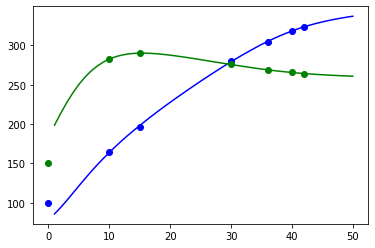

In [24]:
mse_loss = torch.nn.MSELoss(reduction='none')


def ode_loss(y_true, y_pred):
    mask = torch.sum(y_true, dim=-1, keepdim=True) > 0
    mask = mask.float()

    return torch.sum(mask * mse_loss(y_true, y_pred)) / mask.sum()


if __name__ == '__main__':

    steps, h = 50, 1

    ori_series = {0: [100, 150],
                  10: [165, 283],
                  15: [197, 290],
                  30: [280, 276],
                  36: [305, 269],
                  40: [318, 266],
                  42: [324, 264]}

    # 归一化
    series = {}
    for k, v in ori_series.items():
        series[k] = [(v[0] - 100) / (324 - 100), (v[1] - 150) / (264 - 150)]

    X = np.array([series[0]])
    Y = np.zeros((1, steps, 2))

    for i, j in series.items():
        if i != 0:
            Y[0, int(i / h) - 1] += series[i]

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    model = ODE_LSTM(steps, input_size=2, hidden_size=64, num_layers=2)
    optimizer = Adam(model.parameters(), lr=1e-4)

    for epoch in range(1500):
        outputs = model(X)
        loss = ode_loss(Y, outputs)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        print(epoch, loss.item())

    with torch.no_grad():
        result = model(torch.tensor([[0, 0]], dtype=torch.float32))[0]
        result = result * torch.tensor([324 - 100, 264 - 150], dtype=torch.float32) + \
                 torch.tensor([100, 150], dtype=torch.float32)
        times = np.arange(1, steps + 1) * h

    plot.clf()
    plot.plot(times, result[:, 0], color='blue')
    plot.plot(times, result[:, 1], color='green')

    plot.plot(list(ori_series.keys()), [i[0] for i in ori_series.values()], 'o', color='blue')
    plot.plot(list(ori_series.keys()), [i[1] for i in ori_series.values()], 'o', color='green')

## 